In [1]:
import os
import cv2
import random
import contextlib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, datasets, models

!pip install mtcnn
from mtcnn.mtcnn import MTCNN

#To parse xml files
!pip install xmltodict
import xmltodict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.5 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -qq "/content/drive/MyDrive/Project Deals/Pattern_Recognition/Project/Data/archive.zip"

In [4]:
image_path="/content/images/"
ann_path="/content/annotations/"

save_folder="/content/drive/MyDrive/Project Deals/Pattern_Recognition/Project/weight"

In [5]:
name_to_label={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}
label_to_name={label:name for name,label in name_to_label.items()}

In [6]:
num_classes=3

#Loading images from kaggle dataset

In [7]:
#Load image paths
image_names=os.listdir(image_path)
#Load annotations paths
ann_names=os.listdir(ann_path)

###Loading data for classification model

In [8]:
req_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

In [9]:
def dataset_from_files(image_names):
  image_tensor=[]
  label_tensor=[]
  for i,j in enumerate(image_names):
    with open(os.path.join(ann_path,j[:-4]+".xml")) as fd:
        xml_obj=xmltodict.parse(fd.read())

    if type(xml_obj["annotation"]["object"])!=list:
      xml_obj["annotation"]["object"]=[xml_obj["annotation"]["object"]]

    for ann_ind in xml_obj["annotation"]["object"]:
      x,y,w,h=list(map(int,ann_ind["bndbox"].values()))
      label=name_to_label[ann_ind["name"]]
      image=transforms.functional.crop(Image.open(os.path.join(image_path,j)).convert("RGB"),y,x,h-y,w-x)
      image_tensor.append(req_transform(image))
      label_tensor.append(torch.tensor(label))

  final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
  return tuple(final_dataset)

In [10]:
mydataset=dataset_from_files(image_names)
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [11]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

In [12]:
train_dataloader = DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader = DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


###Know you data:

In [13]:
data = {}
for _,label in mydataset:
  v=label.item()
  label_class=label_to_name[v]
  data[label_class]=data.get(label_class,0)+1

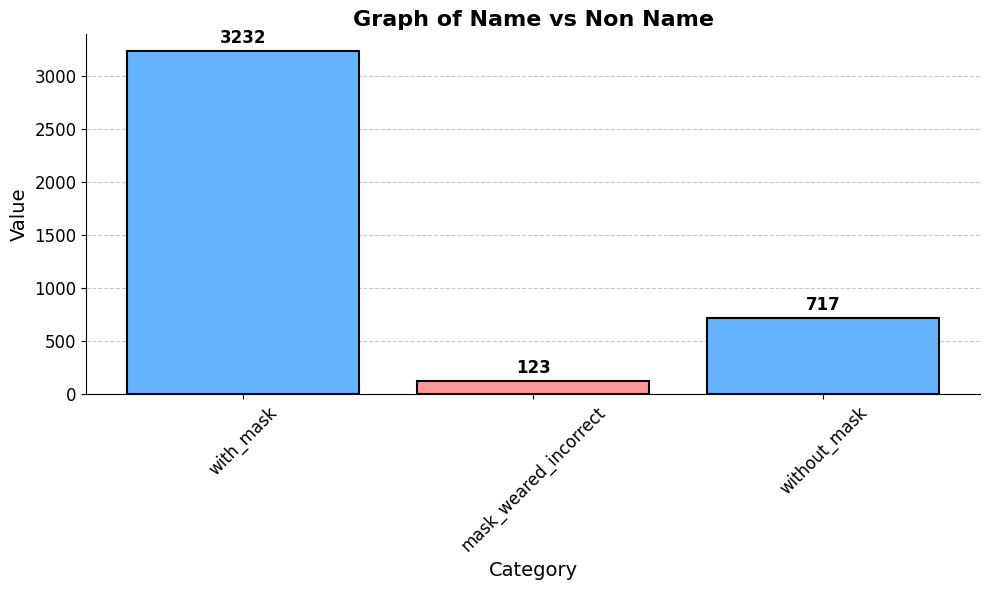

In [14]:
# Extracting keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

# Define a custom color palette
colors = ['#66b3ff', '#ff9999']

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, values, color=colors, edgecolor='black', linewidth=1.5)

# Adding data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Category", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Graph of Name vs Non Name", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Remove the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding a background grid
plt.gca().set_axisbelow(True)

plt.show()

#Model Training

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class FocalCrossEntropyLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalCrossEntropyLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        if self.alpha is None:
            alpha_t = 1.0
        else:
            alpha_t = self.alpha

        pt = torch.exp(-ce_loss)
        focal_loss = (alpha_t * (1 - pt) ** self.gamma * ce_loss).mean()

        return focal_loss.sum()

In [17]:
def train_transfer(num_epochs,model,optimizer,criterion):
  Train_loss=[]
  Train_accuracy=[]
  for epoch in tqdm(range(num_epochs)):
      train_loss = 0.0
      train_total = 0
      train_correct = 0

      for i, (images, labels) in enumerate(train_dataloader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          model.train()
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          train_loss += loss.item() * images.size(0)

          # Accuracy
          _,predicted = torch.max(outputs.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()

      train_loss = train_loss / len(train_dataloader.dataset)
      train_accuracy = train_correct / train_total

      #Appending value at each epoch
      Train_accuracy.append(train_accuracy)
      Train_loss.append(train_loss)

      print(f"Epoch [{epoch+1}/{num_epochs}] : Train Loss: {train_loss:.4f},  Train Accuracy: {train_accuracy:.4f}")
  info=[Train_accuracy,Train_loss]
  return model,info

In [18]:
#Method to test the model
def test_model(model, criterion, data_loader):
  model.eval()  # Set the model to evaluation mode
  total_correct = 0
  total_samples = 0
  total_loss = 0.0
  y_test=np.array([])
  y_pred=np.array([])
  with torch.no_grad():
      for inputs, labels in data_loader:
          inputs=inputs.to(device)
          labels=labels.to(device)
          outputs = model(inputs)
          outputs = torch.squeeze(outputs)
          _,predicted = torch.max(outputs.data, 1)
          y_test=np.append(y_test,labels.cpu().numpy())
          y_pred=np.append(y_pred,predicted.cpu().numpy())
  print("Test Accuracy is:",(y_test==y_pred).sum()/len(y_test))

##1. VGG model

###A. Adam optimizer and Focal loss function

In [19]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

#Adding our classifier
vgg_model.classifier = nn.Sequential(
    nn.Linear(7*7*512, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

#Define optimizer and loss function
model_vgg = vgg_model.to(device)
vgg_optimizer_adam = optim.Adam(model_vgg.parameters(), lr=0.0001)
criterion_focal = FocalCrossEntropyLoss(alpha=0.25, gamma=1.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 255MB/s]


In [20]:
model_vgg,vgg_info_adam_focal=train_transfer(num_epochs=15,model=model_vgg,optimizer=vgg_optimizer_adam,criterion=criterion_focal)

  7%|▋         | 1/15 [00:25<06:00, 25.74s/it]

Epoch [1/15] : Train Loss: 0.0477,  Train Accuracy: 0.8354


 13%|█▎        | 2/15 [00:44<04:38, 21.39s/it]

Epoch [2/15] : Train Loss: 0.0250,  Train Accuracy: 0.8972


 20%|██        | 3/15 [01:02<04:02, 20.22s/it]

Epoch [3/15] : Train Loss: 0.0175,  Train Accuracy: 0.9354


 27%|██▋       | 4/15 [01:21<03:36, 19.71s/it]

Epoch [4/15] : Train Loss: 0.0135,  Train Accuracy: 0.9470


 33%|███▎      | 5/15 [01:40<03:14, 19.46s/it]

Epoch [5/15] : Train Loss: 0.0120,  Train Accuracy: 0.9579


 40%|████      | 6/15 [02:00<02:54, 19.43s/it]

Epoch [6/15] : Train Loss: 0.0104,  Train Accuracy: 0.9600


 47%|████▋     | 7/15 [02:19<02:34, 19.26s/it]

Epoch [7/15] : Train Loss: 0.0081,  Train Accuracy: 0.9695


 53%|█████▎    | 8/15 [02:38<02:14, 19.17s/it]

Epoch [8/15] : Train Loss: 0.0071,  Train Accuracy: 0.9775


 60%|██████    | 9/15 [02:57<01:54, 19.12s/it]

Epoch [9/15] : Train Loss: 0.0080,  Train Accuracy: 0.9688


 67%|██████▋   | 10/15 [03:16<01:35, 19.08s/it]

Epoch [10/15] : Train Loss: 0.0087,  Train Accuracy: 0.9663


 73%|███████▎  | 11/15 [03:34<01:16, 19.01s/it]

Epoch [11/15] : Train Loss: 0.0061,  Train Accuracy: 0.9772


 80%|████████  | 12/15 [03:54<00:57, 19.10s/it]

Epoch [12/15] : Train Loss: 0.0053,  Train Accuracy: 0.9821


 87%|████████▋ | 13/15 [04:13<00:38, 19.05s/it]

Epoch [13/15] : Train Loss: 0.0047,  Train Accuracy: 0.9835


 93%|█████████▎| 14/15 [04:32<00:19, 19.04s/it]

Epoch [14/15] : Train Loss: 0.0045,  Train Accuracy: 0.9846


100%|██████████| 15/15 [04:51<00:00, 19.43s/it]

Epoch [15/15] : Train Loss: 0.0045,  Train Accuracy: 0.9856


In [21]:
test_model(model_vgg,criterion_focal,test_dataloader)

Test Accuracy is: 0.9173486088379705


In [22]:
torch.save(model_vgg,os.path.join(save_folder,"vgg_model_adam_focal.pickle"))

###B. Adam optimizer and CrossEntrophy loss

In [23]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

#Adding our classifier
vgg_model.classifier = nn.Sequential(
    nn.Linear(7*7*512, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

#Define optimizer and loss function
model_vgg = vgg_model.to(device)
vgg_optimizer_adam = optim.Adam(model_vgg.parameters(), lr=0.0001)
criterion_CE = nn.CrossEntropyLoss()

In [24]:
model_vgg,vgg_info_adam_ce=train_transfer(num_epochs=15,model=model_vgg,optimizer=vgg_optimizer_adam,criterion=criterion_CE)

  7%|▋         | 1/15 [00:19<04:30, 19.29s/it]

Epoch [1/15] : Train Loss: 0.4150,  Train Accuracy: 0.8361


 13%|█▎        | 2/15 [00:38<04:13, 19.49s/it]

Epoch [2/15] : Train Loss: 0.2402,  Train Accuracy: 0.8979


 20%|██        | 3/15 [00:57<03:51, 19.30s/it]

Epoch [3/15] : Train Loss: 0.1647,  Train Accuracy: 0.9340


 27%|██▋       | 4/15 [01:17<03:31, 19.19s/it]

Epoch [4/15] : Train Loss: 0.1391,  Train Accuracy: 0.9446


 33%|███▎      | 5/15 [01:36<03:11, 19.16s/it]

Epoch [5/15] : Train Loss: 0.1143,  Train Accuracy: 0.9561


 40%|████      | 6/15 [01:55<02:52, 19.12s/it]

Epoch [6/15] : Train Loss: 0.0913,  Train Accuracy: 0.9688


 47%|████▋     | 7/15 [02:14<02:33, 19.17s/it]

Epoch [7/15] : Train Loss: 0.0858,  Train Accuracy: 0.9695


 53%|█████▎    | 8/15 [02:33<02:13, 19.08s/it]

Epoch [8/15] : Train Loss: 0.0737,  Train Accuracy: 0.9719


 60%|██████    | 9/15 [02:52<01:54, 19.03s/it]

Epoch [9/15] : Train Loss: 0.0703,  Train Accuracy: 0.9733


 67%|██████▋   | 10/15 [03:11<01:35, 19.07s/it]

Epoch [10/15] : Train Loss: 0.0596,  Train Accuracy: 0.9796


 73%|███████▎  | 11/15 [03:30<01:16, 19.05s/it]

Epoch [11/15] : Train Loss: 0.0679,  Train Accuracy: 0.9740


 80%|████████  | 12/15 [03:49<00:57, 19.05s/it]

Epoch [12/15] : Train Loss: 0.0563,  Train Accuracy: 0.9796


 87%|████████▋ | 13/15 [04:08<00:38, 19.09s/it]

Epoch [13/15] : Train Loss: 0.0493,  Train Accuracy: 0.9825


 93%|█████████▎| 14/15 [04:27<00:19, 19.06s/it]

Epoch [14/15] : Train Loss: 0.0471,  Train Accuracy: 0.9846


100%|██████████| 15/15 [04:46<00:00, 19.12s/it]

Epoch [15/15] : Train Loss: 0.0478,  Train Accuracy: 0.9789


In [25]:
test_model(model_vgg,criterion_CE,test_dataloader)

Test Accuracy is: 0.9189852700490998


In [26]:
torch.save(model_vgg,os.path.join(save_folder,"vgg_model_adam_ce.pickle"))

###C. SGD optimizer and CrossEntrophy loss

In [27]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

#Adding our classifier
vgg_model.classifier = nn.Sequential(
    nn.Linear(7*7*512, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

#Define optimizer and loss function
model_vgg = vgg_model.to(device)
criterion_CE = nn.CrossEntropyLoss()
vgg_optimizer_SGD = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [28]:
model_vgg,vgg_info_sgd_ce=train_transfer(num_epochs=15,model=model_vgg,optimizer=vgg_optimizer_SGD,criterion=criterion_CE)

  7%|▋         | 1/15 [00:17<04:08, 17.76s/it]

Epoch [1/15] : Train Loss: 0.5494,  Train Accuracy: 0.7821


 13%|█▎        | 2/15 [00:36<03:55, 18.09s/it]

Epoch [2/15] : Train Loss: 0.4068,  Train Accuracy: 0.8249


 20%|██        | 3/15 [00:54<03:36, 18.07s/it]

Epoch [3/15] : Train Loss: 0.3400,  Train Accuracy: 0.8593


 27%|██▋       | 4/15 [01:11<03:16, 17.84s/it]

Epoch [4/15] : Train Loss: 0.2975,  Train Accuracy: 0.8758


 33%|███▎      | 5/15 [01:29<02:57, 17.74s/it]

Epoch [5/15] : Train Loss: 0.2676,  Train Accuracy: 0.8926


 40%|████      | 6/15 [01:47<02:40, 17.81s/it]

Epoch [6/15] : Train Loss: 0.2443,  Train Accuracy: 0.9116


 47%|████▋     | 7/15 [02:05<02:22, 17.86s/it]

Epoch [7/15] : Train Loss: 0.2327,  Train Accuracy: 0.9070


 53%|█████▎    | 8/15 [02:22<02:04, 17.79s/it]

Epoch [8/15] : Train Loss: 0.2120,  Train Accuracy: 0.9207


 60%|██████    | 9/15 [02:40<01:46, 17.71s/it]

Epoch [9/15] : Train Loss: 0.2032,  Train Accuracy: 0.9211


 67%|██████▋   | 10/15 [02:58<01:28, 17.76s/it]

Epoch [10/15] : Train Loss: 0.1890,  Train Accuracy: 0.9274


 73%|███████▎  | 11/15 [03:15<01:11, 17.79s/it]

Epoch [11/15] : Train Loss: 0.1726,  Train Accuracy: 0.9375


 80%|████████  | 12/15 [03:33<00:53, 17.74s/it]

Epoch [12/15] : Train Loss: 0.1686,  Train Accuracy: 0.9372


 87%|████████▋ | 13/15 [03:51<00:35, 17.75s/it]

Epoch [13/15] : Train Loss: 0.1893,  Train Accuracy: 0.9228


 93%|█████████▎| 14/15 [04:09<00:17, 17.82s/it]

Epoch [14/15] : Train Loss: 0.1546,  Train Accuracy: 0.9421


100%|██████████| 15/15 [04:27<00:00, 17.81s/it]

Epoch [15/15] : Train Loss: 0.1555,  Train Accuracy: 0.9330


In [29]:
test_model(model_vgg,criterion_CE,test_dataloader)

Test Accuracy is: 0.8960720130932897


In [30]:
torch.save(model_vgg,os.path.join(save_folder,"vgg_model_sgd_ce.pickle"))

###D. SGD optimizer Focal loss

In [31]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

#Adding our classifier
vgg_model.classifier = nn.Sequential(
    nn.Linear(7*7*512, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

#Define optimizer and loss function
model_vgg = vgg_model.to(device)
criterion_focal = FocalCrossEntropyLoss(alpha=0.25, gamma=1.5)
vgg_optimizer_SGD = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [32]:
model_vgg,vgg_info_sgd_focal=train_transfer(num_epochs=15,model=model_vgg,optimizer=vgg_optimizer_SGD,criterion=criterion_focal)

  7%|▋         | 1/15 [00:17<04:06, 17.63s/it]

Epoch [1/15] : Train Loss: 0.0719,  Train Accuracy: 0.7874


 13%|█▎        | 2/15 [00:35<03:53, 17.95s/it]

Epoch [2/15] : Train Loss: 0.0570,  Train Accuracy: 0.7975


 20%|██        | 3/15 [00:53<03:35, 17.97s/it]

Epoch [3/15] : Train Loss: 0.0516,  Train Accuracy: 0.8074


 27%|██▋       | 4/15 [01:11<03:16, 17.83s/it]

Epoch [4/15] : Train Loss: 0.0467,  Train Accuracy: 0.8235


 33%|███▎      | 5/15 [01:28<02:57, 17.71s/it]

Epoch [5/15] : Train Loss: 0.0441,  Train Accuracy: 0.8330


 40%|████      | 6/15 [01:46<02:39, 17.72s/it]

Epoch [6/15] : Train Loss: 0.0409,  Train Accuracy: 0.8442


 47%|████▋     | 7/15 [02:04<02:22, 17.81s/it]

Epoch [7/15] : Train Loss: 0.0386,  Train Accuracy: 0.8558


 53%|█████▎    | 8/15 [02:22<02:04, 17.83s/it]

Epoch [8/15] : Train Loss: 0.0366,  Train Accuracy: 0.8730


 60%|██████    | 9/15 [02:40<01:46, 17.78s/it]

Epoch [9/15] : Train Loss: 0.0352,  Train Accuracy: 0.8758


 67%|██████▋   | 10/15 [02:57<01:28, 17.75s/it]

Epoch [10/15] : Train Loss: 0.0337,  Train Accuracy: 0.8863


 73%|███████▎  | 11/15 [03:15<01:11, 17.84s/it]

Epoch [11/15] : Train Loss: 0.0328,  Train Accuracy: 0.8877


 80%|████████  | 12/15 [03:33<00:53, 17.83s/it]

Epoch [12/15] : Train Loss: 0.0318,  Train Accuracy: 0.8881


 87%|████████▋ | 13/15 [03:51<00:35, 17.75s/it]

Epoch [13/15] : Train Loss: 0.0307,  Train Accuracy: 0.8937


 93%|█████████▎| 14/15 [04:08<00:17, 17.73s/it]

Epoch [14/15] : Train Loss: 0.0300,  Train Accuracy: 0.8972


100%|██████████| 15/15 [04:26<00:00, 17.80s/it]

Epoch [15/15] : Train Loss: 0.0292,  Train Accuracy: 0.8898


In [33]:
test_model(model_vgg,criterion_focal,test_dataloader)

Test Accuracy is: 0.8723404255319149


In [34]:
torch.save(model_vgg,os.path.join(save_folder,"vgg_model_sgd_focal.pickle"))

###Same model comparison:

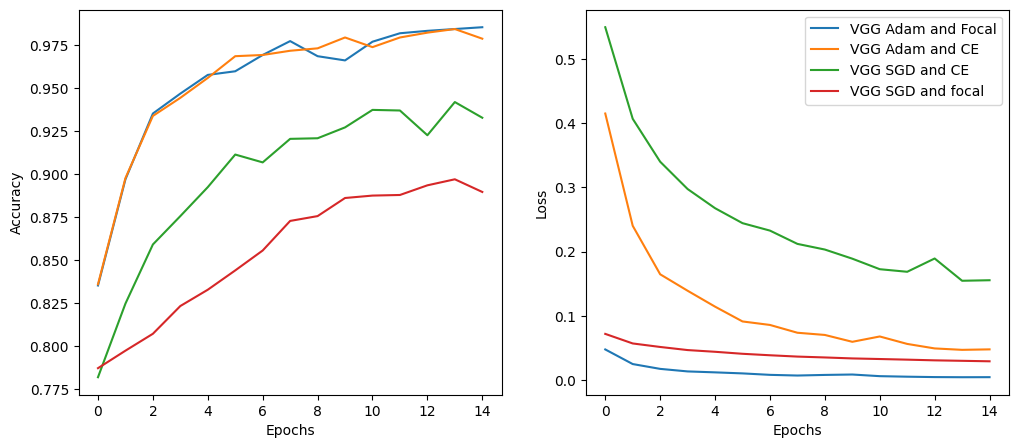

In [35]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(vgg_info_sgd_focal[0]))
axs[0].plot(x_axis,vgg_info_adam_focal[0],label="VGG Adam and Focal")
axs[0].plot(x_axis,vgg_info_adam_ce[0],label="VGG Adam and CE")
axs[0].plot(x_axis,vgg_info_sgd_ce[0],label="VGG SGD and CE")
axs[0].plot(x_axis,vgg_info_sgd_focal[0],label="VGG SGD and focal")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,vgg_info_adam_focal[1],label="VGG Adam and Focal")
axs[1].plot(x_axis,vgg_info_adam_ce[1],label="VGG Adam and CE")
axs[1].plot(x_axis,vgg_info_sgd_ce[1],label="VGG SGD and CE")
axs[1].plot(x_axis,vgg_info_sgd_focal[1],label="VGG SGD and focal")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

##2. Resnet model

###A. Adam optimizer and Focal loss function

In [36]:
resnet_model = models.resnet34(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_resnet = resnet_model.to(device)
resnet_optimizer_adam = optim.Adam(model_resnet.parameters(), lr=0.0001)
criterion_focal = FocalCrossEntropyLoss(alpha=0.25, gamma=1.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.6MB/s]


In [37]:
model_resnet,resnet_info_adam_focal=train_transfer(num_epochs=15,model=model_resnet,optimizer=resnet_optimizer_adam,criterion=criterion_focal)

  7%|▋         | 1/15 [00:07<01:42,  7.34s/it]

Epoch [1/15] : Train Loss: 0.0507,  Train Accuracy: 0.8421


 13%|█▎        | 2/15 [00:14<01:36,  7.41s/it]

Epoch [2/15] : Train Loss: 0.0372,  Train Accuracy: 0.8972


 20%|██        | 3/15 [00:21<01:25,  7.15s/it]

Epoch [3/15] : Train Loss: 0.0323,  Train Accuracy: 0.9060


 27%|██▋       | 4/15 [00:28<01:18,  7.14s/it]

Epoch [4/15] : Train Loss: 0.0272,  Train Accuracy: 0.9154


 33%|███▎      | 5/15 [00:35<01:10,  7.02s/it]

Epoch [5/15] : Train Loss: 0.0271,  Train Accuracy: 0.9140


 40%|████      | 6/15 [00:42<01:03,  7.08s/it]

Epoch [6/15] : Train Loss: 0.0246,  Train Accuracy: 0.9260


 47%|████▋     | 7/15 [00:49<00:55,  6.98s/it]

Epoch [7/15] : Train Loss: 0.0248,  Train Accuracy: 0.9193


 53%|█████▎    | 8/15 [00:56<00:49,  7.02s/it]

Epoch [8/15] : Train Loss: 0.0229,  Train Accuracy: 0.9249


 60%|██████    | 9/15 [01:03<00:41,  6.94s/it]

Epoch [9/15] : Train Loss: 0.0210,  Train Accuracy: 0.9284


 67%|██████▋   | 10/15 [01:10<00:34,  6.97s/it]

Epoch [10/15] : Train Loss: 0.0222,  Train Accuracy: 0.9249


 73%|███████▎  | 11/15 [01:17<00:27,  6.90s/it]

Epoch [11/15] : Train Loss: 0.0217,  Train Accuracy: 0.9291


 80%|████████  | 12/15 [01:24<00:20,  6.96s/it]

Epoch [12/15] : Train Loss: 0.0189,  Train Accuracy: 0.9393


 87%|████████▋ | 13/15 [01:31<00:13,  6.89s/it]

Epoch [13/15] : Train Loss: 0.0184,  Train Accuracy: 0.9382


 93%|█████████▎| 14/15 [01:38<00:06,  6.98s/it]

Epoch [14/15] : Train Loss: 0.0193,  Train Accuracy: 0.9351


100%|██████████| 15/15 [01:44<00:00,  7.00s/it]

Epoch [15/15] : Train Loss: 0.0213,  Train Accuracy: 0.9284


In [38]:
test_model(model_resnet,criterion_focal,test_dataloader)

Test Accuracy is: 0.9181669394435352


In [39]:
torch.save(model_resnet,os.path.join(save_folder,"resnet_model_adam_focal.pickle"))

###B. Adam optimizer and CrossEntrophy loss

In [40]:
resnet_model = models.resnet34(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_resnet = resnet_model.to(device)
resnet_optimizer_adam = optim.Adam(model_resnet.parameters(), lr=0.0001)
criterion_CE = nn.CrossEntropyLoss()

In [41]:
model_resnet,resnet_info_adam_ce=train_transfer(num_epochs=15,model=model_resnet,optimizer=resnet_optimizer_adam,criterion=criterion_CE)

  7%|▋         | 1/15 [00:06<01:32,  6.59s/it]

Epoch [1/15] : Train Loss: 0.4583,  Train Accuracy: 0.8411


 13%|█▎        | 2/15 [00:13<01:31,  7.01s/it]

Epoch [2/15] : Train Loss: 0.3076,  Train Accuracy: 0.8986


 20%|██        | 3/15 [00:20<01:21,  6.81s/it]

Epoch [3/15] : Train Loss: 0.2669,  Train Accuracy: 0.9074


 27%|██▋       | 4/15 [00:27<01:16,  6.95s/it]

Epoch [4/15] : Train Loss: 0.2558,  Train Accuracy: 0.9053


 33%|███▎      | 5/15 [00:34<01:08,  6.80s/it]

Epoch [5/15] : Train Loss: 0.2347,  Train Accuracy: 0.9144


 40%|████      | 6/15 [00:41<01:02,  6.89s/it]

Epoch [6/15] : Train Loss: 0.2234,  Train Accuracy: 0.9253


 47%|████▋     | 7/15 [00:47<00:54,  6.75s/it]

Epoch [7/15] : Train Loss: 0.2089,  Train Accuracy: 0.9239


 53%|█████▎    | 8/15 [00:54<00:48,  6.89s/it]

Epoch [8/15] : Train Loss: 0.2293,  Train Accuracy: 0.9189


 60%|██████    | 9/15 [01:01<00:40,  6.76s/it]

Epoch [9/15] : Train Loss: 0.2067,  Train Accuracy: 0.9256


 67%|██████▋   | 10/15 [01:08<00:34,  6.86s/it]

Epoch [10/15] : Train Loss: 0.1899,  Train Accuracy: 0.9319


 73%|███████▎  | 11/15 [01:14<00:27,  6.76s/it]

Epoch [11/15] : Train Loss: 0.1947,  Train Accuracy: 0.9326


 80%|████████  | 12/15 [01:21<00:20,  6.84s/it]

Epoch [12/15] : Train Loss: 0.1874,  Train Accuracy: 0.9312


 87%|████████▋ | 13/15 [01:28<00:13,  6.80s/it]

Epoch [13/15] : Train Loss: 0.2020,  Train Accuracy: 0.9235


 93%|█████████▎| 14/15 [01:35<00:06,  6.82s/it]

Epoch [14/15] : Train Loss: 0.1603,  Train Accuracy: 0.9396


100%|██████████| 15/15 [01:42<00:00,  6.82s/it]

Epoch [15/15] : Train Loss: 0.1788,  Train Accuracy: 0.9365


In [42]:
test_model(model_resnet,criterion_CE,test_dataloader)

Test Accuracy is: 0.9247135842880524


In [43]:
torch.save(model_resnet,os.path.join(save_folder,"resnet_model_adam_ce.pickle"))

###C. SGD optimizer and CrossEntrophy loss

In [44]:
resnet_model = models.resnet34(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_resnet = resnet_model.to(device)
resnet_optimizer_sgd = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion_CE = nn.CrossEntropyLoss()

In [45]:
model_resnet,resnet_info_sgd_ce=train_transfer(num_epochs=15,model=model_resnet,optimizer=resnet_optimizer_sgd,criterion=criterion_CE)

  7%|▋         | 1/15 [00:06<01:31,  6.50s/it]

Epoch [1/15] : Train Loss: 0.4805,  Train Accuracy: 0.8221


 13%|█▎        | 2/15 [00:13<01:29,  6.87s/it]

Epoch [2/15] : Train Loss: 0.3613,  Train Accuracy: 0.8751


 20%|██        | 3/15 [00:20<01:20,  6.75s/it]

Epoch [3/15] : Train Loss: 0.3007,  Train Accuracy: 0.9000


 27%|██▋       | 4/15 [00:27<01:15,  6.83s/it]

Epoch [4/15] : Train Loss: 0.2754,  Train Accuracy: 0.9018


 33%|███▎      | 5/15 [00:33<01:07,  6.80s/it]

Epoch [5/15] : Train Loss: 0.2662,  Train Accuracy: 0.9035


 40%|████      | 6/15 [00:40<01:01,  6.85s/it]

Epoch [6/15] : Train Loss: 0.2558,  Train Accuracy: 0.9109


 47%|████▋     | 7/15 [00:47<00:54,  6.84s/it]

Epoch [7/15] : Train Loss: 0.2643,  Train Accuracy: 0.8993


 53%|█████▎    | 8/15 [00:54<00:48,  6.90s/it]

Epoch [8/15] : Train Loss: 0.2355,  Train Accuracy: 0.9140


 60%|██████    | 9/15 [01:01<00:41,  6.90s/it]

Epoch [9/15] : Train Loss: 0.2408,  Train Accuracy: 0.9126


 67%|██████▋   | 10/15 [01:08<00:34,  6.92s/it]

Epoch [10/15] : Train Loss: 0.2166,  Train Accuracy: 0.9246


 73%|███████▎  | 11/15 [01:15<00:27,  6.88s/it]

Epoch [11/15] : Train Loss: 0.2133,  Train Accuracy: 0.9274


 80%|████████  | 12/15 [01:22<00:20,  6.88s/it]

Epoch [12/15] : Train Loss: 0.2173,  Train Accuracy: 0.9193


 87%|████████▋ | 13/15 [01:29<00:13,  6.89s/it]

Epoch [13/15] : Train Loss: 0.2077,  Train Accuracy: 0.9235


 93%|█████████▎| 14/15 [01:35<00:06,  6.86s/it]

Epoch [14/15] : Train Loss: 0.2295,  Train Accuracy: 0.9133


100%|██████████| 15/15 [01:42<00:00,  6.86s/it]

Epoch [15/15] : Train Loss: 0.1977,  Train Accuracy: 0.9316


In [46]:
test_model(model_resnet,criterion_CE,test_dataloader)

Test Accuracy is: 0.8968903436988543


In [47]:
torch.save(model_resnet,os.path.join(save_folder,"resnet_model_sgd_ce.pickle"))

###D. SGD optimizer Focal loss

In [48]:
resnet_model = models.resnet34(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_resnet = resnet_model.to(device)
resnet_optimizer_sgd = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion_focal = FocalCrossEntropyLoss(alpha=0.25, gamma=1.5)

In [49]:
model_resnet,resnet_info_sgd_focal=train_transfer(num_epochs=15,model=model_resnet,optimizer=resnet_optimizer_sgd,criterion=criterion_focal)

  7%|▋         | 1/15 [00:07<01:40,  7.18s/it]

Epoch [1/15] : Train Loss: 0.0689,  Train Accuracy: 0.7758


 13%|█▎        | 2/15 [00:13<01:28,  6.82s/it]

Epoch [2/15] : Train Loss: 0.0499,  Train Accuracy: 0.8516


 20%|██        | 3/15 [00:20<01:23,  6.95s/it]

Epoch [3/15] : Train Loss: 0.0445,  Train Accuracy: 0.8681


 27%|██▋       | 4/15 [00:27<01:14,  6.78s/it]

Epoch [4/15] : Train Loss: 0.0419,  Train Accuracy: 0.8761


 33%|███▎      | 5/15 [00:34<01:09,  6.92s/it]

Epoch [5/15] : Train Loss: 0.0386,  Train Accuracy: 0.8870


 40%|████      | 6/15 [00:41<01:01,  6.79s/it]

Epoch [6/15] : Train Loss: 0.0377,  Train Accuracy: 0.8867


 47%|████▋     | 7/15 [00:48<00:55,  6.89s/it]

Epoch [7/15] : Train Loss: 0.0360,  Train Accuracy: 0.9011


 53%|█████▎    | 8/15 [00:54<00:47,  6.77s/it]

Epoch [8/15] : Train Loss: 0.0369,  Train Accuracy: 0.8965


 60%|██████    | 9/15 [01:01<00:41,  6.84s/it]

Epoch [9/15] : Train Loss: 0.0332,  Train Accuracy: 0.9049


 67%|██████▋   | 10/15 [01:08<00:33,  6.74s/it]

Epoch [10/15] : Train Loss: 0.0334,  Train Accuracy: 0.9007


 73%|███████▎  | 11/15 [01:15<00:27,  6.84s/it]

Epoch [11/15] : Train Loss: 0.0315,  Train Accuracy: 0.9137


 80%|████████  | 12/15 [01:21<00:20,  6.80s/it]

Epoch [12/15] : Train Loss: 0.0320,  Train Accuracy: 0.9014


 87%|████████▋ | 13/15 [01:28<00:13,  6.85s/it]

Epoch [13/15] : Train Loss: 0.0311,  Train Accuracy: 0.9088


 93%|█████████▎| 14/15 [01:35<00:06,  6.81s/it]

Epoch [14/15] : Train Loss: 0.0307,  Train Accuracy: 0.9095


100%|██████████| 15/15 [01:42<00:00,  6.84s/it]

Epoch [15/15] : Train Loss: 0.0311,  Train Accuracy: 0.9098


In [50]:
test_model(model_resnet,criterion_focal,test_dataloader)

Test Accuracy is: 0.9124386252045826


In [51]:
torch.save(model_resnet,os.path.join(save_folder,"resnet_model_sgd_focal.pickle"))

###Same model comparison:

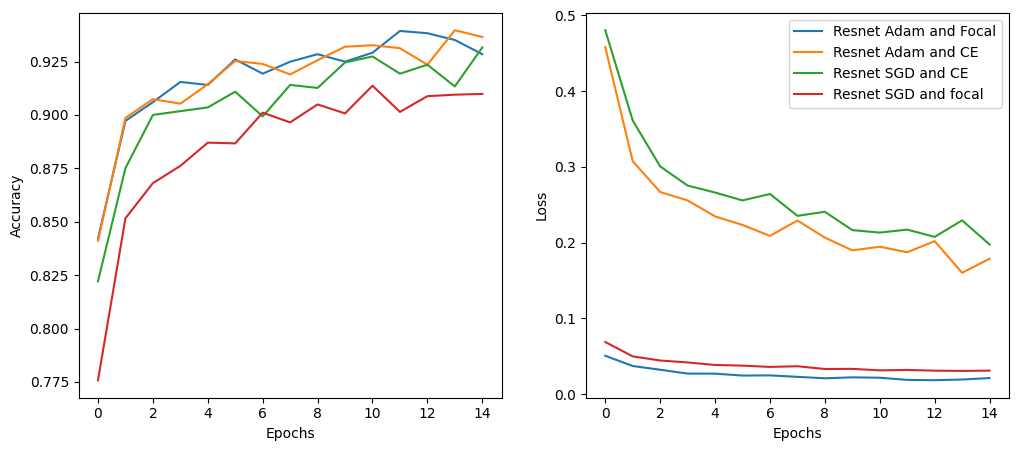

In [52]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(resnet_info_sgd_focal[0]))
axs[0].plot(x_axis,resnet_info_adam_focal[0],label="Resnet Adam and Focal")
axs[0].plot(x_axis,resnet_info_adam_ce[0],label="Resnet Adam and CE")
axs[0].plot(x_axis,resnet_info_sgd_ce[0],label="Resnet SGD and CE")
axs[0].plot(x_axis,resnet_info_sgd_focal[0],label="Resnet SGD and focal")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,resnet_info_adam_focal[1],label="Resnet Adam and Focal")
axs[1].plot(x_axis,resnet_info_adam_ce[1],label="Resnet Adam and CE")
axs[1].plot(x_axis,resnet_info_sgd_ce[1],label="Resnet SGD and CE")
axs[1].plot(x_axis,resnet_info_sgd_focal[1],label="Resnet SGD and focal")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

##3. Efficientnet model

###A. Adam optimizer and Focal loss function

In [53]:
efficientnet_model = models.efficientnet_b0(pretrained=True)
for param in efficientnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(16*16*5, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_efficientnet = efficientnet_model.to(device)
efficientnet_optimizer_adam = optim.Adam(model_efficientnet.parameters(), lr=0.0001)
criterion_focal = FocalCrossEntropyLoss(alpha=0.25, gamma=1.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 59.2MB/s]


In [54]:
model_efficientnet,efficientnet_info_adam_focal=train_transfer(num_epochs=15,model=model_efficientnet,optimizer=efficientnet_optimizer_adam,criterion=criterion_focal)

  7%|▋         | 1/15 [00:06<01:35,  6.84s/it]

Epoch [1/15] : Train Loss: 0.0605,  Train Accuracy: 0.8172


 13%|█▎        | 2/15 [00:13<01:28,  6.81s/it]

Epoch [2/15] : Train Loss: 0.0379,  Train Accuracy: 0.8916


 20%|██        | 3/15 [00:20<01:20,  6.67s/it]

Epoch [3/15] : Train Loss: 0.0318,  Train Accuracy: 0.9060


 27%|██▋       | 4/15 [00:27<01:14,  6.77s/it]

Epoch [4/15] : Train Loss: 0.0278,  Train Accuracy: 0.9137


 33%|███▎      | 5/15 [00:33<01:06,  6.65s/it]

Epoch [5/15] : Train Loss: 0.0245,  Train Accuracy: 0.9295


 40%|████      | 6/15 [00:40<01:00,  6.74s/it]

Epoch [6/15] : Train Loss: 0.0233,  Train Accuracy: 0.9260


 47%|████▋     | 7/15 [00:46<00:52,  6.62s/it]

Epoch [7/15] : Train Loss: 0.0219,  Train Accuracy: 0.9270


 53%|█████▎    | 8/15 [00:53<00:47,  6.75s/it]

Epoch [8/15] : Train Loss: 0.0200,  Train Accuracy: 0.9330


 60%|██████    | 9/15 [01:00<00:39,  6.59s/it]

Epoch [9/15] : Train Loss: 0.0180,  Train Accuracy: 0.9414


 67%|██████▋   | 10/15 [01:07<00:33,  6.72s/it]

Epoch [10/15] : Train Loss: 0.0179,  Train Accuracy: 0.9400


 73%|███████▎  | 11/15 [01:13<00:26,  6.57s/it]

Epoch [11/15] : Train Loss: 0.0168,  Train Accuracy: 0.9446


 80%|████████  | 12/15 [01:20<00:20,  6.71s/it]

Epoch [12/15] : Train Loss: 0.0142,  Train Accuracy: 0.9537


 87%|████████▋ | 13/15 [01:26<00:13,  6.58s/it]

Epoch [13/15] : Train Loss: 0.0147,  Train Accuracy: 0.9498


 93%|█████████▎| 14/15 [01:33<00:06,  6.72s/it]

Epoch [14/15] : Train Loss: 0.0127,  Train Accuracy: 0.9561


100%|██████████| 15/15 [01:39<00:00,  6.66s/it]

Epoch [15/15] : Train Loss: 0.0140,  Train Accuracy: 0.9519


In [55]:
test_model(model_efficientnet,criterion_focal,test_dataloader)

Test Accuracy is: 0.925531914893617


In [56]:
torch.save(model_efficientnet,os.path.join(save_folder,"efficientnet_model_adam_focal.pickle"))

###B. Adam optimizer and CrossEntrophy loss

In [57]:
efficientnet_model = models.efficientnet_b0(pretrained=True)
for param in efficientnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(16*16*5, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_efficientnet = efficientnet_model.to(device)
efficientnet_optimizer_adam = optim.Adam(model_efficientnet.parameters(), lr=0.0001)
criterion_CE = nn.CrossEntropyLoss()

In [58]:
model_efficientnet,efficientnet_info_adam_ce=train_transfer(num_epochs=15,model=model_efficientnet,optimizer=efficientnet_optimizer_adam,criterion=criterion_CE)

  7%|▋         | 1/15 [00:06<01:30,  6.49s/it]

Epoch [1/15] : Train Loss: 0.5461,  Train Accuracy: 0.7996


 13%|█▎        | 2/15 [00:13<01:25,  6.59s/it]

Epoch [2/15] : Train Loss: 0.3537,  Train Accuracy: 0.8839


 20%|██        | 3/15 [00:19<01:19,  6.61s/it]

Epoch [3/15] : Train Loss: 0.2965,  Train Accuracy: 0.8986


 27%|██▋       | 4/15 [00:26<01:12,  6.57s/it]

Epoch [4/15] : Train Loss: 0.2639,  Train Accuracy: 0.9081


 33%|███▎      | 5/15 [00:33<01:06,  6.64s/it]

Epoch [5/15] : Train Loss: 0.2550,  Train Accuracy: 0.9084


 40%|████      | 6/15 [00:39<00:59,  6.57s/it]

Epoch [6/15] : Train Loss: 0.2314,  Train Accuracy: 0.9211


 47%|████▋     | 7/15 [00:46<00:53,  6.68s/it]

Epoch [7/15] : Train Loss: 0.2137,  Train Accuracy: 0.9235


 53%|█████▎    | 8/15 [00:52<00:45,  6.57s/it]

Epoch [8/15] : Train Loss: 0.2004,  Train Accuracy: 0.9256


 60%|██████    | 9/15 [00:59<00:40,  6.69s/it]

Epoch [9/15] : Train Loss: 0.1814,  Train Accuracy: 0.9386


 67%|██████▋   | 10/15 [01:05<00:32,  6.55s/it]

Epoch [10/15] : Train Loss: 0.1737,  Train Accuracy: 0.9418


 73%|███████▎  | 11/15 [01:12<00:26,  6.71s/it]

Epoch [11/15] : Train Loss: 0.1686,  Train Accuracy: 0.9432


 80%|████████  | 12/15 [01:19<00:19,  6.58s/it]

Epoch [12/15] : Train Loss: 0.1562,  Train Accuracy: 0.9442


 87%|████████▋ | 13/15 [01:26<00:13,  6.69s/it]

Epoch [13/15] : Train Loss: 0.1540,  Train Accuracy: 0.9463


 93%|█████████▎| 14/15 [01:32<00:06,  6.56s/it]

Epoch [14/15] : Train Loss: 0.1622,  Train Accuracy: 0.9404


100%|██████████| 15/15 [01:39<00:00,  6.63s/it]

Epoch [15/15] : Train Loss: 0.1589,  Train Accuracy: 0.9432


In [59]:
test_model(model_efficientnet,criterion_CE,test_dataloader)

Test Accuracy is: 0.9304418985270049


In [60]:
torch.save(model_efficientnet,os.path.join(save_folder,"efficientnet_model_adam_ce.pickle"))

###C. SGD optimizer and CrossEntrophy loss

In [61]:
efficientnet_model = models.efficientnet_b0(pretrained=True)
for param in efficientnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(16*16*5, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_efficientnet = efficientnet_model.to(device)
efficientnet_optimizer_sgd = optim.SGD(model_efficientnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion_CE = nn.CrossEntropyLoss()

In [62]:
model_efficientnet,efficientnet_info_sgd_ce=train_transfer(num_epochs=15,model=model_efficientnet,optimizer=efficientnet_optimizer_sgd,criterion=criterion_CE)

  7%|▋         | 1/15 [00:06<01:31,  6.52s/it]

Epoch [1/15] : Train Loss: 0.6495,  Train Accuracy: 0.7688


 13%|█▎        | 2/15 [00:13<01:25,  6.54s/it]

Epoch [2/15] : Train Loss: 0.5420,  Train Accuracy: 0.7912


 20%|██        | 3/15 [00:19<01:17,  6.43s/it]

Epoch [3/15] : Train Loss: 0.5034,  Train Accuracy: 0.7937


 27%|██▋       | 4/15 [00:26<01:12,  6.57s/it]

Epoch [4/15] : Train Loss: 0.4637,  Train Accuracy: 0.8039


 33%|███▎      | 5/15 [00:32<01:04,  6.48s/it]

Epoch [5/15] : Train Loss: 0.4351,  Train Accuracy: 0.8404


 40%|████      | 6/15 [00:39<00:59,  6.61s/it]

Epoch [6/15] : Train Loss: 0.4024,  Train Accuracy: 0.8453


 47%|████▋     | 7/15 [00:45<00:51,  6.47s/it]

Epoch [7/15] : Train Loss: 0.3766,  Train Accuracy: 0.8681


 53%|█████▎    | 8/15 [00:52<00:45,  6.56s/it]

Epoch [8/15] : Train Loss: 0.3584,  Train Accuracy: 0.8775


 60%|██████    | 9/15 [00:58<00:38,  6.44s/it]

Epoch [9/15] : Train Loss: 0.3472,  Train Accuracy: 0.8761


 67%|██████▋   | 10/15 [01:05<00:33,  6.60s/it]

Epoch [10/15] : Train Loss: 0.3307,  Train Accuracy: 0.8884


 73%|███████▎  | 11/15 [01:11<00:25,  6.46s/it]

Epoch [11/15] : Train Loss: 0.3111,  Train Accuracy: 0.8996


 80%|████████  | 12/15 [01:18<00:19,  6.55s/it]

Epoch [12/15] : Train Loss: 0.3095,  Train Accuracy: 0.8947


 87%|████████▋ | 13/15 [01:24<00:12,  6.45s/it]

Epoch [13/15] : Train Loss: 0.2976,  Train Accuracy: 0.9028


 93%|█████████▎| 14/15 [01:31<00:06,  6.50s/it]

Epoch [14/15] : Train Loss: 0.2906,  Train Accuracy: 0.9049


100%|██████████| 15/15 [01:37<00:00,  6.51s/it]

Epoch [15/15] : Train Loss: 0.2899,  Train Accuracy: 0.9007


In [63]:
test_model(model_efficientnet,criterion_CE,test_dataloader)

Test Accuracy is: 0.9165302782324058


In [64]:
torch.save(model_efficientnet,os.path.join(save_folder,"efficientnet_model_sgd_ce.pickle"))

###D. SGD optimizer Focal loss

In [74]:
efficientnet_model = models.efficientnet_b0(pretrained=True)
for param in efficientnet_model.parameters():
    param.requires_grad = False

#Adding fully connected layer
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(16*16*5, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

model_efficientnet = efficientnet_model.to(device)
efficientnet_optimizer_sgd = optim.SGD(model_efficientnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion_focal = FocalCrossEntropyLoss(alpha=0.25, gamma=1.5)

In [75]:
model_efficientnet,efficientnet_info_sgd_focal=train_transfer(num_epochs=15,model=model_efficientnet,optimizer=efficientnet_optimizer_sgd,criterion=criterion_focal)

  7%|▋         | 1/15 [00:07<01:38,  7.00s/it]

Epoch [1/15] : Train Loss: 0.0892,  Train Accuracy: 0.7635


 13%|█▎        | 2/15 [00:13<01:25,  6.55s/it]

Epoch [2/15] : Train Loss: 0.0699,  Train Accuracy: 0.7912


 20%|██        | 3/15 [00:19<01:18,  6.57s/it]

Epoch [3/15] : Train Loss: 0.0661,  Train Accuracy: 0.7912


 27%|██▋       | 4/15 [00:26<01:11,  6.53s/it]

Epoch [4/15] : Train Loss: 0.0644,  Train Accuracy: 0.7916


 33%|███▎      | 5/15 [00:32<01:05,  6.54s/it]

Epoch [5/15] : Train Loss: 0.0633,  Train Accuracy: 0.7916


 40%|████      | 6/15 [00:39<00:59,  6.57s/it]

Epoch [6/15] : Train Loss: 0.0616,  Train Accuracy: 0.7916


 47%|████▋     | 7/15 [00:46<00:52,  6.56s/it]

Epoch [7/15] : Train Loss: 0.0605,  Train Accuracy: 0.7940


 53%|█████▎    | 8/15 [00:52<00:46,  6.59s/it]

Epoch [8/15] : Train Loss: 0.0584,  Train Accuracy: 0.7951


 60%|██████    | 9/15 [00:59<00:39,  6.52s/it]

Epoch [9/15] : Train Loss: 0.0570,  Train Accuracy: 0.7961


 67%|██████▋   | 10/15 [01:05<00:32,  6.56s/it]

Epoch [10/15] : Train Loss: 0.0565,  Train Accuracy: 0.8049


 73%|███████▎  | 11/15 [01:11<00:25,  6.45s/it]

Epoch [11/15] : Train Loss: 0.0546,  Train Accuracy: 0.8109


 80%|████████  | 12/15 [01:18<00:19,  6.60s/it]

Epoch [12/15] : Train Loss: 0.0544,  Train Accuracy: 0.8077


 87%|████████▋ | 13/15 [01:25<00:12,  6.47s/it]

Epoch [13/15] : Train Loss: 0.0534,  Train Accuracy: 0.8235


 93%|█████████▎| 14/15 [01:31<00:06,  6.60s/it]

Epoch [14/15] : Train Loss: 0.0519,  Train Accuracy: 0.8260


100%|██████████| 15/15 [01:38<00:00,  6.54s/it]

Epoch [15/15] : Train Loss: 0.0510,  Train Accuracy: 0.8326


In [76]:
test_model(model_efficientnet,criterion_focal,test_dataloader)

Test Accuracy is: 0.8445171849427169


In [77]:
torch.save(model_efficientnet,os.path.join(save_folder,"efficientnet_model_sgd_focal.pickle"))

###Same model comparison:

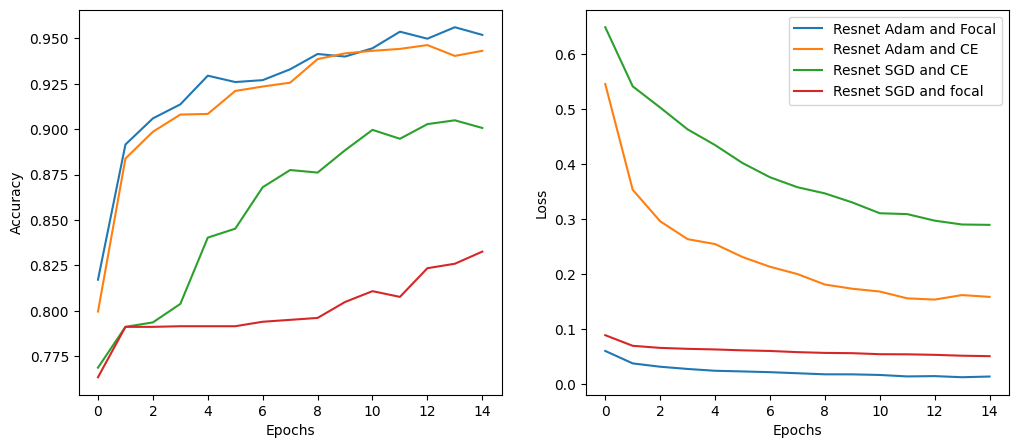

In [78]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(efficientnet_info_sgd_focal[0]))
axs[0].plot(x_axis,efficientnet_info_adam_focal[0],label="Resnet Adam and Focal")
axs[0].plot(x_axis,efficientnet_info_adam_ce[0],label="Resnet Adam and CE")
axs[0].plot(x_axis,efficientnet_info_sgd_ce[0],label="Resnet SGD and CE")
axs[0].plot(x_axis,efficientnet_info_sgd_focal[0],label="Resnet SGD and focal")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,efficientnet_info_adam_focal[1],label="Resnet Adam and Focal")
axs[1].plot(x_axis,efficientnet_info_adam_ce[1],label="Resnet Adam and CE")
axs[1].plot(x_axis,efficientnet_info_sgd_ce[1],label="Resnet SGD and CE")
axs[1].plot(x_axis,efficientnet_info_sgd_focal[1],label="Resnet SGD and focal")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

##Comparision between VGG16, Resnet32 and EfficientNet

###1. Adam and CE

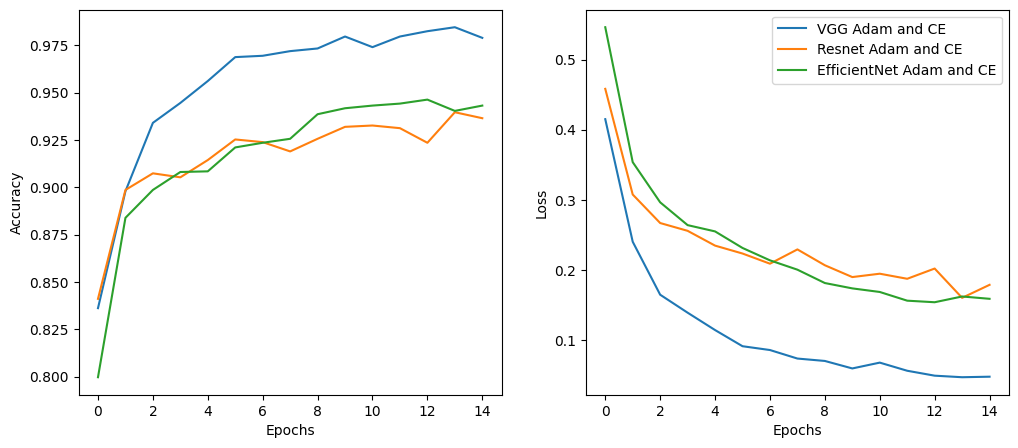

In [83]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(vgg_info_adam_ce[0]))
axs[0].plot(x_axis,vgg_info_adam_ce[0],label="VGG Adam and CE")
axs[0].plot(x_axis,resnet_info_adam_ce[0],label="Resnet Adam and CE")
axs[0].plot(x_axis,efficientnet_info_adam_ce[0],label="EfficientNet Adam and CE")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,vgg_info_adam_ce[1],label="VGG Adam and CE")
axs[1].plot(x_axis,resnet_info_adam_ce[1],label="Resnet Adam and CE")
axs[1].plot(x_axis,efficientnet_info_adam_ce[1],label="EfficientNet Adam and CE")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

###2. Adam and focal

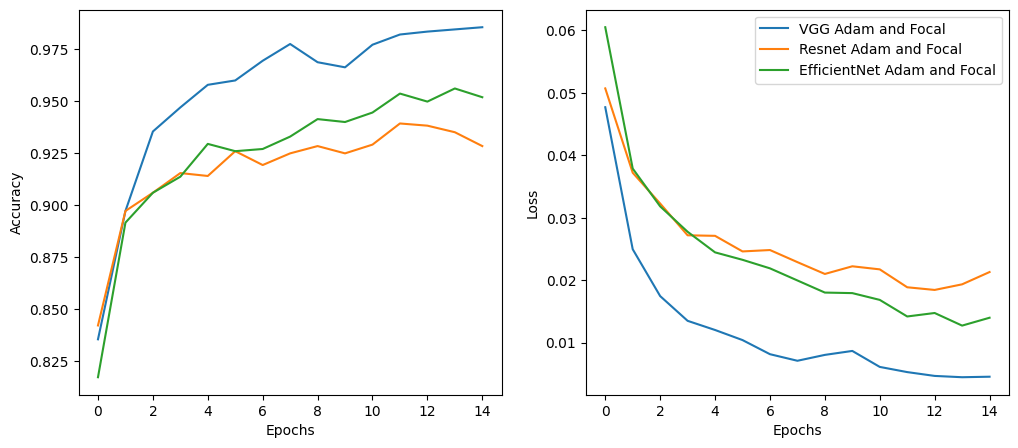

In [84]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(resnet_info_adam_focal[0]))
axs[0].plot(x_axis,vgg_info_adam_focal[0],label="VGG Adam and Focal")
axs[0].plot(x_axis,resnet_info_adam_focal[0],label="Resnet Adam and Focal")
axs[0].plot(x_axis,efficientnet_info_adam_focal[0],label="EfficientNet Adam and Focal")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,vgg_info_adam_focal[1],label="VGG Adam and Focal")
axs[1].plot(x_axis,resnet_info_adam_focal[1],label="Resnet Adam and Focal")
axs[1].plot(x_axis,efficientnet_info_adam_focal[1],label="EfficientNet Adam and Focal")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

###3. SGD and focal

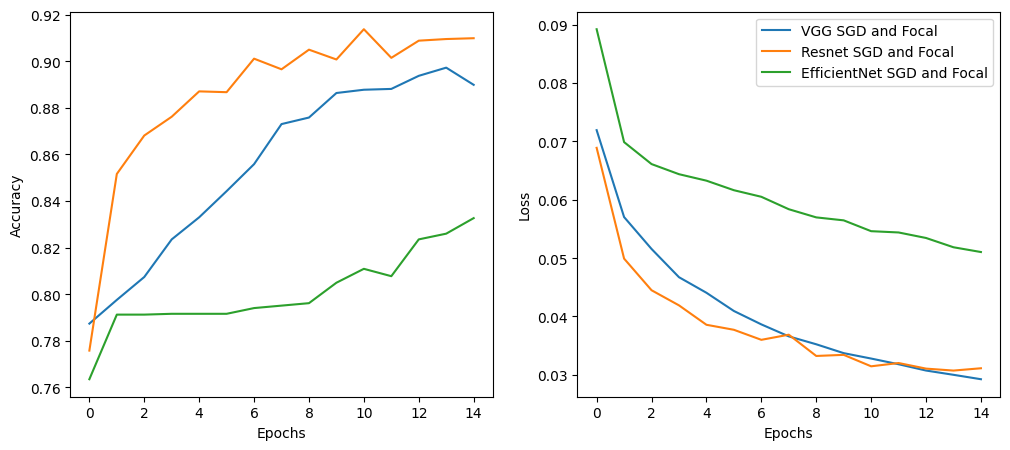

In [85]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(resnet_info_sgd_focal[0]))
axs[0].plot(x_axis,vgg_info_sgd_focal[0],label="VGG SGD and Focal")
axs[0].plot(x_axis,resnet_info_sgd_focal[0],label="Resnet SGD and Focal")
axs[0].plot(x_axis,efficientnet_info_sgd_focal[0],label="EfficientNet SGD and Focal")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,vgg_info_sgd_focal[1],label="VGG SGD and Focal")
axs[1].plot(x_axis,resnet_info_sgd_focal[1],label="Resnet SGD and Focal")
axs[1].plot(x_axis,efficientnet_info_sgd_focal[1],label="EfficientNet SGD and Focal")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

###4. SGD and CE

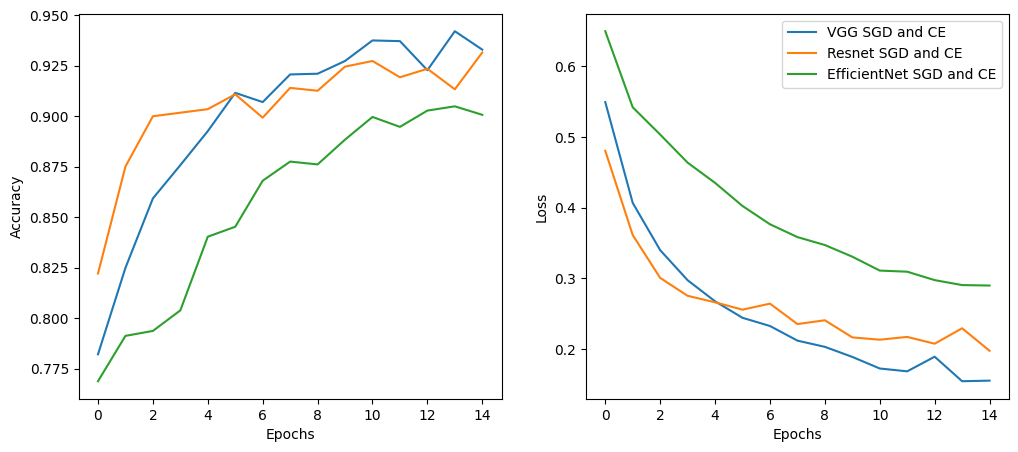

In [86]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

x_axis=range(len(resnet_info_sgd_ce[0]))
axs[0].plot(x_axis,vgg_info_sgd_ce[0],label="VGG SGD and CE")
axs[0].plot(x_axis,resnet_info_sgd_ce[0],label="Resnet SGD and CE")
axs[0].plot(x_axis,efficientnet_info_sgd_ce[0],label="EfficientNet SGD and CE")
axs[0].set(ylabel="Accuracy")
axs[0].set(xlabel="Epochs")

axs[1].plot(x_axis,vgg_info_sgd_ce[1],label="VGG SGD and CE")
axs[1].plot(x_axis,resnet_info_sgd_ce[1],label="Resnet SGD and CE")
axs[1].plot(x_axis,efficientnet_info_sgd_ce[1],label="EfficientNet SGD and CE")
axs[1].set(ylabel="Loss")
axs[1].set(xlabel="Epochs")

plt.legend()
plt.show()

###Saving and loading models

In [ ]:
# torch.save(model_vgg,os.path.join(save_folder,"vgg_model.pickle"))
# torch.save(model_resnet,os.path.join(save_folder,"resnet_model.pickle"))

In [ ]:
# model_vgg=torch.load(os.path.join(save_folder,"vgg_model.pickle"))
# model_resnet=torch.load(os.path.join(save_folder,"resnet_model.pickle"))
# model_vgg.eval()
# model_resnet.eval()
# print("Done loading models")

Done loading models


#Object detection problem

##Load Data for testing

In [ ]:
inference_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
def inference_dataset_from_files(image_names):
  image_tensor=[]
  label_tensor=[]
  for i,j in enumerate(image_names):
    with open(os.path.join(ann_path,j[:-4]+".xml")) as fd:
        xml_obj=xmltodict.parse(fd.read())

    if type(xml_obj["annotation"]["object"])!=list:
      xml_obj["annotation"]["object"]=[xml_obj["annotation"]["object"]]

    image=Image.open(os.path.join(image_path,j)).convert("RGB")
    image_tensor.append(inference_transform(image))
    annotation={}
    annotation["boxes"]=[list(map(int,ann_ind["bndbox"].values())) for ann_ind in xml_obj["annotation"]["object"]]
    annotation["boxes"]=torch.as_tensor(annotation["boxes"], dtype=torch.float32)
    annotation["labels"]=[name_to_label[ann_ind["name"]] for ann_ind in xml_obj["annotation"]["object"]]
    annotation["labels"]=torch.as_tensor(annotation["labels"], dtype=torch.int64)
    label_tensor.append(annotation)
  final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
  return tuple(final_dataset)

In [ ]:
#Pick two random image
images_list=random.sample(image_names,2)

##Using mtcnn for face detection followed by classification model from above

In [ ]:
def display_test_inference(model,test_img_,y_meta):
  fig,ax = plt.subplots(2,1,figsize=(8,12))
  test_image = test_img_.cpu().data.permute(1, 2, 0).numpy()
  ax[0].imshow(test_image)
  ax[1].imshow(test_image)
  ax[0].set_title("Classifier model result")
  ax[1].set_title("Ground Truth")
  ax[0].axis('off')
  ax[1].axis('off')
  test_image*=255
  test_image=np.uint8(test_image)
  detector = MTCNN()
  with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
      faces=detector.detect_faces(test_image)
  faces=[face["box"] for face in faces]
  for (x,y,w,h) in faces:
    mpatch = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    rx, ry = mpatch.get_xy()
    ax[0].add_patch(mpatch)
    image_=transforms.functional.crop(Image.fromarray(np.uint8(test_image)),y,x,h,w)
    samp=req_transform(image_).unsqueeze(axis=0)
    samp=samp.to(device)
    res=model(samp)
    _,predicted = torch.max(res.data, 1)
    val=predicted.item()
    ax[0].annotate(label_to_name[val], (rx, ry),color="green", weight='bold', fontsize=10, ha='left', va='baseline')

  for box,label in zip(y_meta["boxes"],y_meta["labels"]):
    xmin, ymin, xmax, ymax = box
    mpatch = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    ax[1].add_patch(mpatch)
    rx, ry = mpatch.get_xy()
    val=label.item()
    ax[1].annotate(label_to_name[val], (rx, ry),color="green", weight='bold', fontsize=10, ha='left', va='baseline')
  plt.show()

In [ ]:
test_data=inference_dataset_from_files(images_list)
img,ann=test_data[1]

In [ ]:
#Load the saved model
model_resnet=torch.load(os.path.join(save_folder,"resnet_model_adam_ce.pickle"))
model_resnet.eval()

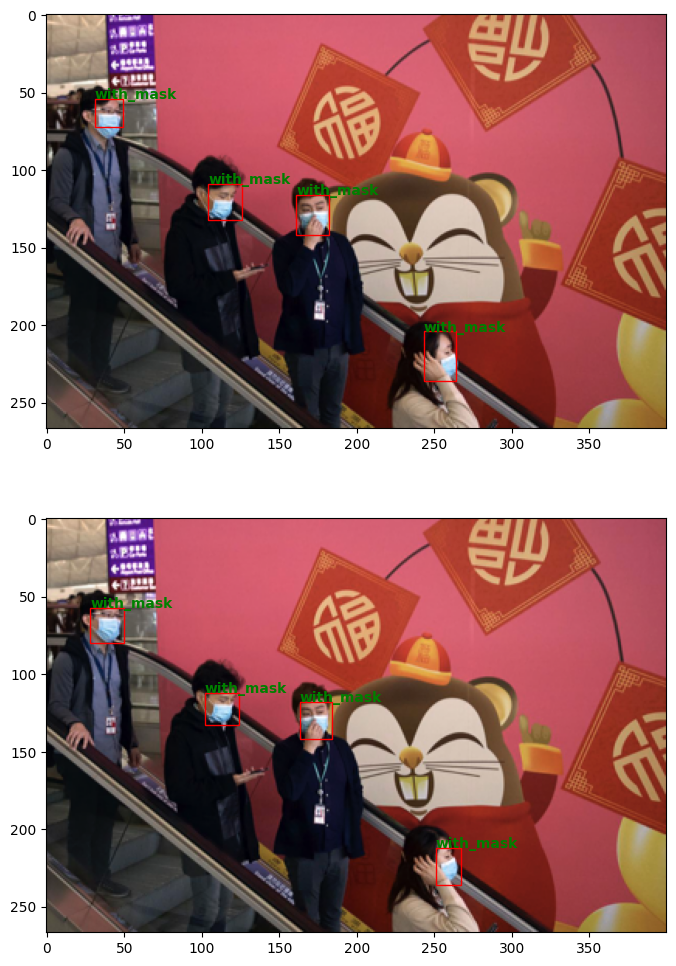

In [ ]:
display_test_inference(model_resnet,img,ann)